In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import glob, sys, os

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from recalibration_utils import *
from session_utils import *

import hmm_utils
from hmm import HMMRecalibration
import stabilizer_utils

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

plt.rcParams['figure.dpi'] = 300 

participant    = 'T11'
FILE_DIR       = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/' + participant + '/'


fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'
files       = glob.glob(os.path.join(FILE_DIR, 't11.*/'))

#block_constraints = getBlockConstraints(FILE_DIR)
#files             = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)

In [5]:
class T11DataStruct(object):
    """
    Generates a simplified R struct from cursor data.
    """
    def __init__(self, file, alignScreens = False, causal_filter = 0):
        
        assert isinstance(file, str), "<file> must be a string"
        assert isinstance(alignScreens, bool), "<alignScreens> must be bool"
        
        self.date = file.split('t11.')[1].split('/')[0]
        
        blocks    = glob.glob(os.path.join(file, 'Block*'))
        self.blockList = list()
        self.gameName  = list()

        self.cursorPos_continuous = list()
        self.targetPos_continuous = list()
        self.decClick_continuous  = list()
        self.blockID_continuous   = list()
        self.TX_continuous = list()
        self.trialEpochs = list()
        self.decVel = list()
        
        
        for block in sorted(blocks):
            # load data files first:
            datafile  = glob.glob(os.path.join(block, 'data.mat'))[0]
            infofile  = glob.glob(os.path.join(block, 'info.mat'))[0]
            taskfile  = glob.glob(os.path.join(block, 'task.mat'))[0]
            
            data = loadmat(datafile)
            info = loadmat(infofile)
            task = loadmat(taskfile)
            
            blockNumber = int(block.split('_')[-1])
            assert blockNumber == int(info['blockNumber'][0][0]), "File block ID and recorded value differ."
            
            self.blockList.append(blockNumber)
            self.blockID_continuous.append(blockNumber * np.ones((info['cursorPos'].shape[0])))
            self.gameName.append(task['name'][0])
            
            self.cursorPos_continuous.append(info['cursorPos'])
            self.targetPos_continuous.append(info['targetPos'])
            
            decClick = np.zeros((info['targetPos'].shape[0]))
            decClick[task['clickInd']] = 1
            self.decClick_continuous.append(decClick)
            self.decVel.append(info['decVel'])
            
            self.TX_continuous.append(data['data'][:, :192].astype(float))
            self.trialEpochs.append(task['startStops'])
            
        for field in ['cursorPos_continuous', 'targetPos_continuous', 'decClick_continuous',
                    'TX_continuous', 'blockID_continuous', 'trialEpochs', 'decVel']:
            setattr(self, field, np.concatenate(getattr(self, field), axis=0))
            
        self.n_trials                = self.trialEpochs.shape[0]
        self.n_channels              = self.TX_continuous.shape[1] 
        self.displacement_continuous = self.targetPos_continuous - self.cursorPos_continuous

        # now load in neural data and smooth if requested:
        if causal_filter > 0:
            self.TX_continuous = firingrate.gaussian_filter1d(self.TX_continuous, sigma = causal_filter, axis = 0, causal = True)
        
        # align screen coordinates across tasks
        self.screenAligned = False
        if alignScreens:
            self.alignTaskScreens()
            self.screenAligned = True
            

    def alignTaskScreens(self):
        '''Realign screen positioning across different tasks into a common reference frame by centering all
           screens at (0, 0). Inputs are:

            struct (DataStruct) - session data to use 
        '''
        
        if not self.screenAligned:
            screen_realignments = np.load('../utils/misc_data/screen_realignments.npy', allow_pickle = True).item()
            
            for i, task in enumerate(self.trialType):
                    self.cursorPos[i] -= screen_realignments[task]
                    self.targetPos[i] -= screen_realignments[task]

            for i, block in enumerate(self.blockList):
                task  = np.unique(self.trialType[self.blockNums == block])
                start = self.trialEpochs[self.blockNums == block, 0].min()

                try:
                    stop = self.trialEpochs[self.blockNums == self.blockList[i+1], 0].min() - 1
                except:
                    stop  = self.trialEpochs[self.blockNums == block, 1].max()

                assert len(task) == 1, "Error: multiple trial types within a block?"

                self.cursorPos_continuous[(start - 1):stop, :] -= screen_realignments[task[0]]
                self.targetPos_continuous[(start - 1):stop, :] -= screen_realignments[task[0]]

        else:
            print('Screens already aligned across tasks. Skipping.')
            
            
def getBlockData(struct, block, field):
    idxs = np.where(struct.blockID_continuous == block)[0]
    return getattr(struct, field)[min(idxs):max(idxs), ...]


def rollingZScore(train_x, test_x, window_size=600, concatenate=False):
    '''Apply moving average z-score based on past time window.'''
    
    train_x_new, test_x_new = list(), list()
    subtract = [train_x[-1]] + test_x

    for i, x in enumerate(train_x):
        pad_val      = np.std(x, axis = 0)
        running_std  = np.std(rolling_window(x, window_size = 600, padding = pad_val), axis = 1) 
        x_rolling    = x / (running_std + 1)
        train_x_new.append(x_rolling)

    for i, x in enumerate(test_x):
        pad_val      = np.std(subtract[i], axis = 0)
        running_std  = np.std(rolling_window(x, window_size = 600, padding = pad_val), axis = 1) 
        x_rolling    = x / (running_std + 1)
        test_x_new.append(x_rolling)
        
    train_x = train_x_new
    test_x  = test_x_new
        
    if concatenate:
        train_x = np.concatenate(train_x)
        test_x  = np.concatenate(test_x) if test_x != [] else []
        
    return train_x, test_x
            
    
def getFoldPerformances(lm, X, y, n_splits):
    scores = list()
    
    x_folds = np.array_split(X, n_splits, axis=0)
    y_folds = np.array_split(y, n_splits, axis=0)

    for x_chunk, y_chunk in zip(x_folds, y_folds):
        scores.append(np.corrcoef(lm.predict(x_chunk).flatten(), y_chunk.flatten())[0, 1])
        
    return scores
    
    
def crossValidatedOracle(X, y, n_splits):
    '''Train a linear regression model on the test split using cross-validation.
    '''
    scores = list()
    
    x_folds = np.array_split(X, n_splits, axis=0)
    y_folds = np.array_split(y, n_splits, axis=0)

    for idx in range(n_splits):
        x_train = np.concatenate([x_folds[i] for i in np.arange(n_splits) if i != idx])
        y_train = np.concatenate([y_folds[i] for i in np.arange(n_splits) if i != idx])
        
        x_test = x_folds[idx]
        y_test = y_folds[idx]
        
        lm = LinearRegression().fit(x_train, y_train)
        scores.append(np.corrcoef(lm.predict(x_test).flatten(), y_test.flatten())[0, 1])
        
    return scores


def corrBootstrap(x, y, alpha, n_bootstraps = 10000):
    
    assert x.shape == y.shape, "must be same shape"
    
    idxs  = np.random.choice(x.shape[0], (n_bootstraps, x.shape[0]), replace = True)
    corrs = np.corrcoef(x[idxs].reshape(n_bootstraps, -1), y[idxs].reshape(n_bootstraps, -1))[:n_bootstraps, n_bootstraps:]
    corrs = np.diag(corrs)
    upper = np.percentile(corrs, 100 - (alpha/2))
    lower = np.percentile(corrs, alpha/2)
    
    return lower, upper

First let's load T11's free use data and apply some preprocessing (rolling z-scoring). We'll segment blocks into training (free use) and testing (fitts from end-of-day).

In [6]:
session_blocks = dict()
session_blocks['2021.08.26'] = [[13, 14, 15, 17, 19, 20, 21, 22], [5,6,7]]
session_blocks['2022.04.05'] = [[6, 8, 9, 12, 14, 15],[17, 19]]

In [7]:
file                = files[0]
toggle_displacement = True # whether or not to infer displacement or ground-truth decoder outputs
smoothing_sigma     = 10

struct = T11DataStruct(file, causal_filter=smoothing_sigma)

train_blocks, test_blocks = session_blocks[struct.date]

#train_blocks = [6, 8, 9, 12, 14, 15] # free use blocks
#test_blocks  = [17, 19]  # fitts blocks
    
# neural data preprocessing
train_x   = [getBlockData(struct, b, 'TX_continuous') for b in train_blocks]
test_x    = [getBlockData(struct, b, 'TX_continuous') for b in test_blocks]
train_x, test_x = subtractMeans(train_x, test_x, method = 'rolling', concatenate=False)
train_x, test_x = rollingZScore(train_x, test_x, concatenate=True)

# cursor behavior preprocessing
train_vel = np.concatenate([getBlockData(struct, b, 'decVel') for b in train_blocks])
test_vel  = np.concatenate([getBlockData(struct, b, 'decVel') for b in test_blocks])
test_displacement = np.concatenate([getBlockData(struct, b, 'displacement_continuous') for b in test_blocks])

train_cursor    = np.concatenate([getBlockData(struct, b, 'cursorPos_continuous') for b in train_blocks])
train_click     = np.concatenate([getBlockData(struct, b, 'decClick_continuous') for b in train_blocks])

# determine ground-truth signal and also post-processing
test_y = test_displacement if toggle_displacement else test_vel

test_y = test_y[1500:] # remove very start 
test_x = test_x[1500:] # remove very start

bad_idxs = np.unique(np.where(np.isnan(test_y))[0])
test_x   = np.delete(test_x, bad_idxs, axis = 0)
test_y   = np.delete(test_y, bad_idxs, axis = 0)

Example of RTI

RTI train R2: 0.16448563897418667
RTI test corr: 0.196


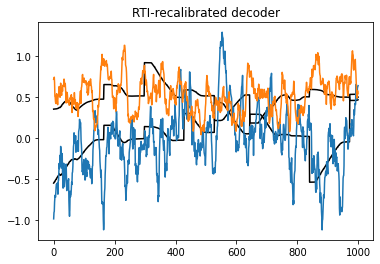

In [8]:
from utils.recalibration.RTI_utils import RTI

look_back = 800
min_dist  = 0.
min_time  = 0

rti          = RTI(look_back, min_dist, min_time)
rti_x, rti_y = rti.label(train_x, train_cursor, train_click)
lm = LinearRegression().fit(rti_x, rti_y)
print('RTI train R2:', lm.score(rti_x, rti_y))

offsets = np.arange(2) * 0.5

plt.plot(test_y[1000:2000, :] + offsets, c ='k')
plt.plot(lm.predict(test_x[1000:2000, :]) + offsets)
plt.title('RTI-recalibrated decoder')
#plt.ylim([-0.05, 0.1])

overall_corr = np.round(np.corrcoef(lm.predict(test_x).flatten(), test_y.flatten()), 4)[0, 1]
print('RTI test corr:', overall_corr)

PRI-T examples

In [24]:
clickProbs  = lambda dist : 1 - 1 / (1 + np.exp(-1 * (dist - 0.1) * 12))


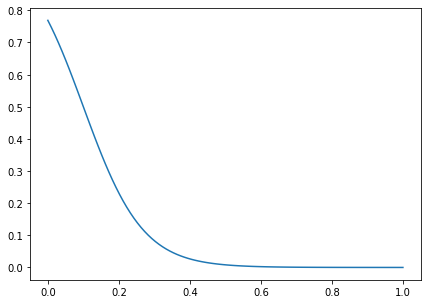

In [25]:
plt.plot(np.linspace(0, 1, 100), clickProbs(np.linspace(0, 1, 100)))

In [26]:
hmm_cfg  = {'gridSize' : 20, 
            'stayProb' : 0.999, 
            'vmKappa' : 2, 
            'inflection' : 2 * (70 /400), 
            'exp' : 0.5, 
            'probThreshold' : 'probWeighted'}


targLocs        = hmm_utils.getMesh([-1, 1], [-1, 1], gridSize = hmm_cfg['gridSize'])
stateTrans, pStateStart = hmm_utils.generateTransitionMatrix(hmm_cfg['gridSize'], hmm_cfg['stayProb'])
    
adjustKappa = lambda dist : 1 / (1 + np.exp(-1 * (dist - hmm_cfg['inflection']) * hmm_cfg['exp']))
clickProbs  = lambda dist : 1 - 1 / (1 + np.exp(-1 * (dist - 0.1) * 12))

# standard PRI-T model
hmm         = HMMRecalibration(stateTrans, targLocs, pStateStart, hmm_cfg['vmKappa'], adjustKappa)

viterbi_seq, targStates = hmm.predict([train_cursor], [train_vel])
maxProb                 = np.max(targStates, axis = 1)  # get P(H_i | O_1, ...., O_n)
inferredTargLoc         = targLocs[viterbi_seq.astype(int), :] 
pseudolabels            = inferredTargLoc - train_cursor

lm        = LinearRegression().fit(train_x, pseudolabels, sample_weight=maxProb)
PRIT_corr = np.round(np.corrcoef(lm.predict(test_x).flatten(), test_y.flatten()), 4)[0, 1]

print('PRI-T train R2:', lm.score(train_x, pseudolabels))
print('PRI-T test corr:', PRIT_corr)

# Click-based PRI-T model
hmm  = HMMRecalibration(stateTrans, targLocs, pStateStart, hmm_cfg['vmKappa'], 
                               adjustKappa, getClickProb=clickProbs)

viterbi_seq, targStates = hmm.predict([train_cursor], [train_vel], [train_click])
click_maxProb           = np.max(targStates, axis = 1)  # get P(H_i | O_1, ...., O_n)
inferredTargLoc         = targLocs[viterbi_seq.astype(int), :] 
click_pseudolabels      = inferredTargLoc - train_cursor

click_lm        = LinearRegression().fit(train_x, click_pseudolabels, sample_weight=maxProb)
click_PRIT_corr = np.round(np.corrcoef(click_lm.predict(test_x).flatten(), test_y.flatten()), 4)[0, 1]


viterbi_seq, targStates = hmm.predict([train_cursor], [train_vel], [train_click])
click_maxProb           = np.max(targStates, axis = 1)  # get P(H_i | O_1, ...., O_n)
inferredTargLoc         = targLocs[viterbi_seq.astype(int), :] 
click_pseudolabels      = inferredTargLoc - train_cursor

print('click PRI-T train R2:', lm.score(train_x, click_pseudolabels))
print('click PRI-T test corr:', click_PRIT_corr)

PRI-T train R2: 0.14428867038028825
PRI-T test corr: 0.3214
click PRI-T train R2: 0.15513590264230798
click PRI-T test corr: 0.3147


**Comparisons**

First let's perform a HP sweep on RTI and use the optimal values

In [7]:
from utils.recalibration.RTI_utils import RTI


split_length_secs = 30
look_back_options = np.arange(200, 2000, 50)
min_dist_options  = np.asarray([0, 0.05, 0.1, 0.15, 0.2])
min_time_options  = np.asarray([0, 20, 40, 60, 80, 100, 120])

# ------------------------
n_splits      = int(test_x.shape[0] // (split_length_secs / 0.02))
RTI_HP_sweeps = np.zeros((len(look_back_options), len(min_dist_options), 
                          len(min_time_options), n_splits))

for i, look_back in enumerate(look_back_options):
    for j, min_dist in enumerate(min_dist_options):
        for k, min_time in enumerate(min_time_options):
    
            # First fit RTI to data
            rti                = RTI(look_back, min_dist, min_time)
            rti_x, rti_y, idxs = rti.label(train_x, train_cursor, train_click, return_indices=True)
            lm                 = LinearRegression().fit(rti_x, rti_y)
            RTI_HP_sweeps[i, j, k, :] = getFoldPerformances(lm, test_x, test_y, n_splits)

            
meanvals = RTI_HP_sweeps.mean(axis=-1)
idxs     = np.unravel_index(np.argmax(meanvals), meanvals.shape)

/tmp/ipykernel_27522/2128713836.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


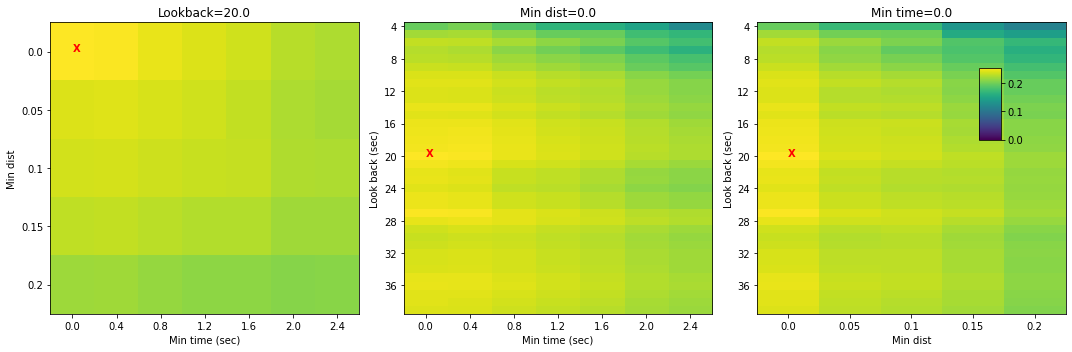

In [8]:
figSize(5, 15)
fig = plt.figure()

vmin, vmax = 0, meanvals.max()

plt.subplot(1,3,1)
plt.imshow(meanvals[idxs[0], :, :], vmin = vmin, vmax= vmax, aspect= 'auto')
plt.yticks(np.arange(len(min_dist_options)), min_dist_options)
plt.xticks(np.arange(len(min_time_options)), min_time_options * 0.02)
plt.xlabel('Min time (sec)')
plt.ylabel('Min dist')
plt.text(idxs[2],idxs[1], s= 'X', c = 'r', fontweight='bold')
plt.title(f'Lookback={look_back_options[idxs[0]] * 0.02}')

plt.subplot(1,3,2)
plt.imshow(meanvals[:, idxs[1], :], vmin = vmin, vmax= vmax, aspect='auto')
plt.yticks(np.arange(len(look_back_options))[::4], (look_back_options * 0.02).astype(int)[::4])
plt.xticks(np.arange(len(min_time_options)), min_time_options * 0.02)
plt.xlabel('Min time (sec)')
plt.ylabel('Look back (sec)')
plt.text(idxs[2],idxs[0], s= 'X', c = 'r', fontweight='bold')
plt.title(f'Min dist={min_dist_options[idxs[1]]}')

plt.subplot(1,3,3)
plt.imshow(meanvals[:, :, idxs[2]], vmin = vmin, vmax= vmax, aspect='auto')
plt.yticks(np.arange(len(look_back_options))[::4], (look_back_options * 0.02).astype(int)[::4])
plt.xticks(np.arange(len(min_dist_options)), min_dist_options)
plt.xlabel('Min dist')
plt.ylabel('Look back (sec)')
plt.text(idxs[1],idxs[0], s= 'X', c = 'r', fontweight='bold')
plt.title(f'Min time={min_time_options[idxs[2]] * 0.02}')


cbar_ax = fig.add_axes([.91, .6, .02, .2])
plt.colorbar(cax=cbar_ax)

plt.tight_layout()

save_fname = os.path.join(fig_path, 'T11')
plt.savefig(os.path.join(save_fname, f'{file}_RTI_HP_sweep.pdf'), format='pdf')

In [15]:
from utils.recalibration.RTI_utils import RTI


split_length_secs = 30
look_back_options = np.concatenate([[25, 50, 75], np.arange(100, 2000, 50)])

# ------------------------
n_splits          = int(test_x.shape[0] // (split_length_secs / 0.02))

lookback_corrs = np.zeros((len(look_back_options), 5, n_splits))
for i, look_back in enumerate(look_back_options):

    min_dist  = min_dist_options[idxs[1]] # optimal RTI
    min_time  = min_time_options[idxs[2]] # optimal RTI
    
    # First fit RTI to data
    rti                    = RTI(look_back, min_dist, min_time)
    rti_x, rti_y, rti_idxs = rti.label(train_x, train_cursor, train_click, return_indices=True)
    lm                     = LinearRegression().fit(rti_x, rti_y)
    lookback_corrs[i, 0, :] = getFoldPerformances(lm, test_x, test_y, n_splits)
     
    # Now fit PRI-T to only the timesteps used by RTI:
    subset_x = train_x[rti_idxs, :]
    subset_y = pseudolabels[rti_idxs]
    lm       = LinearRegression().fit(subset_x, subset_y, sample_weight=maxProb[rti_idxs])
    lookback_corrs[i, 1, :] = getFoldPerformances(lm, test_x, test_y, n_splits)
    
    
# now fit PRI-T to all data:
lm       = LinearRegression().fit(train_x, pseudolabels, sample_weight=maxProb)
lookback_corrs[:, 2, :] = getFoldPerformances(lm, test_x, test_y, n_splits)

# now fit PRI-T with click to all data:
lm       = LinearRegression().fit(train_x, click_pseudolabels, sample_weight=click_maxProb)
lookback_corrs[:, 3, :] = getFoldPerformances(lm, test_x, test_y, n_splits)

# now fit supervised model:
lookback_corrs[:, 4, :] = crossValidatedOracle(test_x, test_y, n_splits)


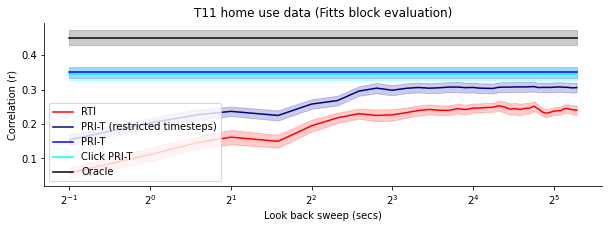

In [17]:
figSize(3, 10)
#plt.rcParams['figure.dpi'] = 300  

colors = ['red', 'darkblue', 'blue', 'cyan', 'k']
labels = ['RTI', 'PRI-T (restricted timesteps)', 'PRI-T', 'Click PRI-T', 'Oracle']

for i, (color, label) in enumerate(zip(colors, labels)):
    plotsd(lookback_corrs[:, i, :].T, time_bins= look_back_options * 0.02,
           color = color, label = label, toggleSE=True)
    #plt.plot(look_back_options, lookback_corrs[:, i], c = color, label = label)
    
#plt.axhline(PRIT_corr, c = 'dodgerblue', label = 'PRI-T', linestyle = '--')
ax = plt.gca()
ax.set_xscale('log', base=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Correlation (r)')
plt.xlabel('Look back sweep (secs)')
plt.title('T11 home use data (Fitts block evaluation)')
plt.legend()


save_fname = os.path.join(fig_path, 'T11')
if not os.path.isdir(save_fname):
    os.makedirs(save_fname)
#plt.savefig(os.path.join(save_fname, f'{file}_lookback_sweep.pdf'), format='pdf')

PRI-T (restricted timesteps) vs. RTI: WilcoxonResult(statistic=4.0, pvalue=2.6702880859375e-05)
Median improvement: 24.9%
PRI-T vs. RTI: WilcoxonResult(statistic=3.0, pvalue=1.9073486328125e-05)
Median improvement: 51.3%
PRI-T vs. PRI-T (restricted timesteps): WilcoxonResult(statistic=27.0, pvalue=0.00457763671875)
Median improvement: 18.1%
Click PRI-T vs. RTI: WilcoxonResult(statistic=5.0, pvalue=3.814697265625e-05)
Median improvement: 42.6%
Click PRI-T vs. PRI-T (restricted timesteps): WilcoxonResult(statistic=38.0, pvalue=0.020412445068359375)
Median improvement: 16.0%
Click PRI-T vs. PRI-T: WilcoxonResult(statistic=81.0, pvalue=0.5948867797851562)
Median improvement: -0.7%
Oracle vs. RTI: WilcoxonResult(statistic=2.0, pvalue=1.1444091796875e-05)
Median improvement: 93.1%
Oracle vs. PRI-T (restricted timesteps): WilcoxonResult(statistic=10.0, pvalue=0.000164031982421875)
Median improvement: 43.7%
Oracle vs. PRI-T: WilcoxonResult(statistic=4.0, pvalue=2.6702880859375e-05)
Median impr

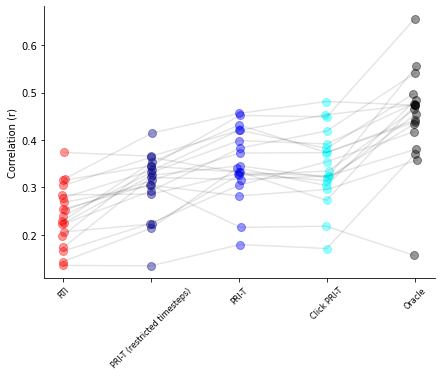

In [18]:
plt_values = lookback_corrs[idxs[0], :, :]


figSize(5, 7)

xvals  = np.vstack([[i] * plt_values.shape[1] for i in range(plt_values.shape[0])]).astype(float)
xvals += np.random.normal(0, 0.01, size = xvals.shape )
yvals  = plt_values

plt.plot(xvals, yvals, c = 'k', alpha = 0.1)
for i in range(xvals.shape[0]):
    plt.plot(xvals[i,:], yvals[i,:], 'o', alpha=.40, zorder=1, ms=8, mew=1, c = colors[i])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(len(labels)), )
ax.set_xticklabels(labels, fontsize= 8, rotation =45)

ax.set_ylabel('Correlation (r)')

for i, label1 in enumerate(labels):
    for j, label2 in enumerate(labels):
        if i > j:
            test = scipy.stats.wilcoxon(plt_values[i, :], plt_values[j, :])
            print(f'{label1} vs. {label2}:', test)
            median_improvement = np.median((plt_values[i, :] - plt_values[j, :])/ np.abs(plt_values[j, :]))
            print(f'Median improvement: {np.round(100 * median_improvement, 1)}%')
            
            
save_fname = os.path.join(fig_path, 'T11', f'{file}_comparisons.pdf')
plt.savefig(save_fname, format='pdf')

Supplementary figure - look at robustness to click model HPs

In [ ]:
clickhmm_cfg = {'gridSize' : 20, 
            'stayProb' : 0.999, 
            'vmKappa' : 2, 
            'inflection' : 2 * (70 /400), 
            'exp' : 0.5, 
            'probThreshold' : 'probWeighted'}

HP_sweep   = np.linspace(0, 0.5, 5)


# -------------------
targLocs        = hmm_utils.getMesh([-1, 1], [-1, 1], gridSize = hmm_cfg['gridSize'])
stateTrans, pStateStart = hmm_utils.generateTransitionMatrix(hmm_cfg['gridSize'], hmm_cfg['stayProb'])
adjustKappa = lambda dist : 1 / (1 + np.exp(-1 * (dist - hmm_cfg['inflection']) * hmm_cfg['exp']))


click_HP_corrs  = np.zeros(HP_sweep.shape)
for i, inflection in enumerate(HP_sweep):
    
    clickProbs = lambda dist : 1 / (1 + np.exp(-1 * (dist - inflection) * 1))
    hmm        = HMMRecalibration(stateTrans, targLocs, pStateStart, hmm_cfg['vmKappa'], 
                                   adjustKappa, getClickProb=clickProbs)    

    viterbi_seq, targStates = hmm.predict([train_cursor], [train_vel], [train_click])
    maxProb            = np.max(targStates, axis = 1)  # get P(H_i | O_1, ...., O_n)
    inferredTargLoc    = targLocs[viterbi_seq.astype(int), :] 
    click_pseudolabels = inferredTargLoc - train_cursor
    
    lm                = LinearRegression().fit(train_x, click_pseudolabels, sample_weight=maxProb)
    click_HP_corrs[i] = getFoldPerformances(lm, test_x, test_vel, n_splits)


In [ ]:
2**4 * 50

In [ ]:
from IPython.display import HTML
from utils.plotting.animatedplots import createHeatmapAnimation

figSize(5, 5)
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  



# video settings
marker_size = 20
cursor_color = 'white'
target_color = 'k'
cmap         = 'hot_r'
toggle_log   = True
frames       = 2000
start_frame  = 1000


# Get RTI target estimates
look_back = 800 #1850
min_dist  = 0
min_time  = 10
rti                    = RTI(look_back, min_dist, min_time)
rti_x, rti_y, rti_idxs = rti.label(train_x, train_cursor, train_click, return_indices=True)

rti_targs           = np.zeros(train_cursor.shape) + np.nan
rti_targs[rti_idxs] = rti_y + train_cursor[rti_idxs]


anim = createHeatmapAnimation(targStates, targLocs, train_cursor, targetPos=rti_targs, toggle_log=toggle_log,
                             cursor_color = cursor_color, marker_size=marker_size, 
                              target_color = target_color, cmap = cmap, 
                              frames = frames, start_frame = start_frame)

HTML(anim.to_jshtml())

#anim.save('../figures/HMM/PRIT_example.mp4')

t5_free_use_days 
- t5.2016.10.31
- t5.2016.12.06
- t5.2016.12.08
- t5.2016.12.19
- t5.2017.01.04

In [ ]:
free_use_days = [
    {'session' : 't5.2016.10.31',
    'free_use_blocks' : [10,11,12,13,14,15,16,17,18],
     'CL blocks' : ,
     'OL blocks' :,
    }
    
    
    
    
]